1 Prepração do notebook
2 Obtenção dos dados, tratamento e geração de Data Frames

* Dados sobre Covid
    * Obtenção de dados do COVID19 e geração do Data Frame df_covid19_br
    * Geração do df_covid19_br_para_shapefile com tratamento dos dados
    * Geração do Geo Data Frames gdf_covid19_br, com os casos para o Brasil, e gdf_covid19_pr, com os casos do Paraná
* Obtenção dos Demais dados
* nível de hierarquia urbana
* população
* mobilidade pendular
* níveis de exportação
* pib percapita
* número de pessoas com renda elevada (a definir o critério)
* tentar identificar uma forma de criar uma base que se atualize dinamicamente e identifique avizinhamento de municípios 0 e 1 

3 Análise Exploratória Correlações

* Gerar painel de estatística descritiva

* Gerar gráficos de distribuição
* Fazer matriz de correlações

4 Modelização

# Obtenção, tratamento e Análise Exploratória dos dados sobre COVID-19 no Brasil

## Preparação do Notebook

* Importação das principais bibliotecas
* Configuração das operações por default (estilos e tamanhos de gráficos)
* Referenciamento das subpastas do projeto

In [ ]:
# importação de bibliotecas básicas

import pandas as pd # Biblioteca para operação avançada com dados tabulares de diversos tipos
import numpy as np # Biblioteca para operação com vetores de auto desempenho e um tipo por vez
from matplotlib import use as mpl_use # Função Matplotlib que estabelece backend e precisa ser chamda antes do plt
mpl_use('nbagg') # uso do backend "nbagg" para os gráficos terem paineis interativos
import matplotlib.pyplot as plt # Biblioteca para geração de gráficos de menor nível de abstração
import seaborn as sns # Biblioteca baseada em matplotlib para geração de gráficos e estilização, com maior nível de abstração
#import geopandas as gpd # Biblioteca de análise geográfica
import descartes # Dependência do Geopandas para poder gerar mapas
import matplotlib 
import os

In [30]:
# configurações das operações por default

# Configuração de DataFrame Pandas para formato numérico com duas casas decimais quando a coluna for float
#pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Apresentação dos gráficos no interior das células
%matplotlib inline 
plt.style.use('ggplot') # Apresentação dos gráficos

# Códigos abaixo são configurações que deixo por opção, caso se tornem úteis em alguma operação
# Configuração das Células para que apresentam múltiplos resultados em vez de apenas o último 
# InteractiveShell.ast_node_interactivity = "all"
# sns.set() # Configuração de Gráficos para padrão de formatação básica da biblioteca Seaborn

In [44]:
# referenciamento das subpastas

diretorio_economia = os.path.join(os.getcwd(),'base_de_dados','economia')
diretorio_casos = os.path.join(os.getcwd(),'base_de_dados','boletins_de_casos')
diretorio_hierarquia_urbana = os.path.join(os.getcwd(),'base_de_dados','hierarquia_urbana')
diretorio_infra_atendimento = os.path.join(os.getcwd(),'base_de_dados','infraestrutura_atendimento')
diretorio_populacao = os.path.join(os.getcwd(),'base_de_dados','populacao')
diretorio_transporte_rodoviario = os.path.join(os.getcwd(),'base_de_dados','transporte_rodoviario')
diretorio_turismo = os.path.join(os.getcwd(),'base_de_dados','turismo')
diretorio_estrutura_territorial = os.path.join(os.getcwd(),'base_de_dados','estrutura_territorial')


## Importação e Tratamento Preliminar dos Dados

* Verificação da Estrutura dos dados
* Observação da pertinência dos tipos
* Identificação e tratamento dos dados nulos
* Codificação de variáveis categóricas
* Separação dos batches
    * Estratificado
    * Não Estratificado
* Criar versão com regularização de escala

São criados três DataFrames

* Dados de Notificações nos municípios brasileiros
    * df_covid_19_br - dados de notificações nos municípios brasileiros
    * df_casos_sem_referencia_municipal
    * df_covid_19_br_to_shape - dados de notificações readequados para importação em ambiente de Sistemas de Informações Geográficas 
    * df_data_primeiro_caso - dados dos da data do primeiro caso

### Dados de notificações nos municípios brasileiros
* Abaixo se encontra uma função colect_cases, que obtem os dados sobre COVID-19 compilados dos boletins e disponível em "https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-cities-time.csv"
    * Os dados são salvos em Pandas Data Frame
    * Os nomes das colunas são corrigidos
    * As duplicidades são eliminadas, pela retirada de várias linhas com totais

Observações: É conveniente que, no futuro, a função tenha um tratamento para que as datas não estejam em formato texto

In [12]:
def colect_cases(output=None, output_format='csv', correct_columns=True, correct_rows=True):
    # Retrieves the notified cases in Brazilian boletins found in
    # https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-cities-time.csv
    # correct_columns -> whether or not to rearrange the columns and rename them
    # Correct_rows -> whether or not to remove the total cases by date, which would duplicate the values per day
    # name_csv -> string withe name of the csv file to save the content of the Data Frame. If name_csv equals to None, no file is saved

    # loads the CSV data into df_cases
    df_cases = pd.read_csv(
        'https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-cities-time.csv',
        parse_dates=True,
        infer_datetime_format=True)

    # if correct_columns == True, it rearranges the columns orders and renames them
    if correct_columns == True:
        df_cases = df_cases[['ibgeID', 'city', 'state', 'date', 'newCases', 'totalCases']].rename(
            columns={'ibgeID': 'cod_mun', 'city': 'municipio', 'state': 'estado', 'date': 'data', 'newCases': 'novos_casos', 'totalCases': 'casos_total'})

    # if correct_rows == True, it removes the rows that show the total cases by date, which would duplicate the values per day
    if correct_rows == True:
        filter_cases_total = df_cases.loc[df_cases.estado == 'TOTAL']
        df_cases.drop(filter_cases_total.index, axis=0, inplace=True)

    # removes the state name in the municipality column
    df_cases.municipio = df_cases.municipio.apply(
        lambda a_corrigir: a_corrigir.split('/')[0])

    # if name_csv contains the name of a csv file, a file will be created in the current directory
    # or in the specified directory
    if output != None:
        if output_format == 'csv':
            df_cases.to_csv(output, encoding='utf-16')
        if output_format == 'excel':
            df_cases.to_excel(output, encoding='utf-16')

    return df_cases

### Importação, observação e tratamento preliminar dos dados

* Criação do Data Frame df_covid_19_br
* observação preliminar dos dados
* identificação de sua estrutura de linhas e colunas

**Data Frame df_covid_19_br**

In [31]:
df_covid_19_br = colect_cases()
df_covid_19_br

,cod_mun,municipio,estado,data,novos_casos,casos_total
0,3550308,São Paulo,SP,2020-02-25,1,1
2,3550308,São Paulo,SP,2020-02-29,1,2
4,3550308,São Paulo,SP,2020-03-04,1,3
6,3550308,São Paulo,SP,2020-03-05,3,6
7,3300407,Barra Mansa,RJ,2020-03-05,1,1
...,...,...,...,...,...,...
4906,3516309,Francisco Morato,SP,2020-04-03,0,3
4907,3523206,Itararé,SP,2020-04-03,0,1
4908,3523909,Itu,SP,2020-04-03,0,1
4909,3525300,Jaú,SP,2020-04-03,0,1


**Informações da estrutura do Data Frame df_covid_19_br**<br>
O Data Frame df_covid_19_br conta com {{len(df_covid_19_br.index)}} linhas e {{len(df_covid_19_br.columns)}} colunas.
A estrutura do df_covid_19_br não é adequada para importação em formato shapefile, necessário para geração de cartogramas 

In [14]:
df_covid_19_br.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4879 entries, 0 to 4910
Data columns (total 6 columns):
cod_mun        4879 non-null int64
municipio      4879 non-null object
estado         4879 non-null object
data           4879 non-null object
novos_casos    4879 non-null int64
casos_total    4879 non-null int64
dtypes: int64(3), object(3)
memory usage: 266.8+ KB


**Dados sem associação com municípios**<br>
Algumas linhas contam o número de casos, mas sem associar a seus municípios, colocando-os como Fora do Estado, Estrangeiro e No-INFO

In [32]:
filter_len_cod_mun = df_covid_19_br.cod_mun.astype('str').str.len() == 2
filter_last_date = df_covid_19_br.data == df_covid_19_br.data.max()

df_casos_sem_referencia_municipal = df_covid_19_br[filter_len_cod_mun].head()

df_covid_19_br[filter_len_cod_mun].head()

,cod_mun,municipio,estado,data,novos_casos,casos_total
123,26,ESTRANGEIRO,PE,2020-03-14,1,1
182,26,ESTRANGEIRO,PE,2020-03-15,0,1
202,26,ESTRANGEIRO,PE,2020-03-16,2,3
277,26,ESTRANGEIRO,PE,2020-03-17,0,3
329,42,ESTRANGEIRO,SC,2020-03-18,2,2


In [16]:
df_covid_19_br[filter_len_cod_mun].municipio.value_counts()

NÃO ESPECIFICADA    71
FORA DO ESTADO      71
ESTRANGEIRO         49
Name: municipio, dtype: int64

**verificação de dados faltantes**

O heatmap abaixo e a série de dados adiante mostram que não existe célula em branco no Data Frame df_covid_19_br

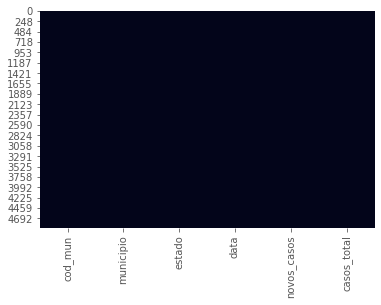

In [17]:
#gráfico heatmap para identificação do padrão de distribuição dos valores nulos no Data Frame
sns.heatmap(df_covid_19_br.isnull(), cbar=False); 

In [18]:
df_covid_19_br.isnull().sum()

cod_mun        0
municipio      0
estado         0
data           0
novos_casos    0
casos_total    0
dtype: int64

In [19]:
dic_data_inicial = {}
cod_municipios = df_covid_19_br[~filter_len_cod_mun].cod_mun.unique()
for codigo in cod_municipios:
    data_inicial = df_covid_19_br[df_covid_19_br.cod_mun == codigo]['data'].min()
    dic_data_inicial[codigo] = data_inicial

In [20]:
df_data_primeiro_caso = pd.DataFrame(data=dic_data_inicial.values(), index=dic_data_inicial.keys(), columns = ['data_primeiro_caso'])

In [21]:
df_data_primeiro_caso

,data_primeiro_caso
3550308,2020-02-25
3300407,2020-03-05
3205200,2020-03-05
2910800,2020-03-06
3304557,2020-03-07
...,...
3516309,2020-04-02
3523206,2020-04-02
3523909,2020-04-02
3525300,2020-04-02


### Geração do Shapefile com os dados de CoronaVirus

In [34]:
def preparing_shape_data(df):
    
    
    # retira os casos do estado que não estão associados a municipios
    filter_len_cod_mun = df.cod_mun.astype('str').str.len() == 2 #filtro de cod_mun de apenas dois caracteres
    df = df[~filter_len_cod_mun] # Retira do Data Frame df as linhas em que cod_mun tem apenas dois caracteres 
    
    # pivoteia o df, com cod_mun na linha, datas nas colunas e casos totais como valores
    df = df[['cod_mun',
              'data',
              'casos_total']].pivot_table(index='cod_mun', columns='data', values='casos_total')
    
    # corrige o nome das colunas
    list_new_column_names = []
    for old_name in df.columns:
        new_name = 'dia' + old_name.split('-')[2]+ old_name.split('-')[1]
        list_new_column_names.append(new_name)
    df.columns = list_new_column_names
    
    
    
    #list_new_column_names = []
    #for old_column_name in df.columns:
    #    new_name = 'dia' + old_column_name.split('-')[1] + old_column_name.split('-')[0]
    #    list_new_column_names.append(new_name)
    #df.columns = list_new_column_names
    
    # insere 0 nos casos em que o valores são nulos
    df.fillna(0, inplace=True)
    
    # transforma os dados em integers
    
    df = df.astype('int32')
    
    
    return df

In [35]:
# Gera o Data Frame com os dados de COVID no formato adequado para importação em Geo Data Frame
df_covid_19_br_to_shape = preparing_shape_data(df_covid_19_br)

In [36]:
# visualização do Data Frame com os dados para importação em Geo Data Frame
df_covid_19_br_to_shape

,dia2502,dia2902,dia0403,dia0503,dia0603,dia0703,dia0803,dia0903,dia1003,dia1103,...,dia2503,dia2603,dia2703,dia2803,dia2903,dia3003,dia3103,dia0104,dia0204,dia0304
cod_mun,,,,,,,,,,,,,,,,,,,,,
1100114,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,1,1
1100122,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1100205,0,0,0,0,0,0,0,0,0,0,...,4,5,5,5,5,6,7,7,8,8
1200013,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,7,7,8,8,8
1200401,0,0,0,0,0,0,0,0,0,0,...,23,24,25,25,31,34,34,34,36,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5218805,0,0,0,0,0,0,0,0,0,0,...,6,6,6,7,7,7,7,7,7,7
5220603,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
5221403,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1


In [ ]:
diretorio_estrutura_territorial = os.path.join(os.getcwd(),'estrutura_territorial')

In [47]:
os.path.join(diretorio_estrutura_territorial,'BRMUE250GC_SIR.shp')

'C:\\Users\\Acer A315\\OneDrive\\covid_19\\base_de_dados\\estrutura_territorial\\BRMUE250GC_SIR.shp'

In [48]:
# Cria o Geo Data Frame com base na shapefile de todos os municipios do Brasil
gdf_municipios_br = gpd.read_file('\base_de_dados\estrutura_territorial\BRMUE250GC_SIR.shp', encoding='utf-8')
gdf_municipios_br

DriverError: 'ase_de_dados\estrutura_territorial\BRMUE250GC_SIR.shp' does not exist in the file system, and is not recognized as a supported dataset name.

In [ ]:
# Verifica a estrutura do Geo Data Frame
gdf_municipios_br.info() 

In [ ]:
# Renomeia as colunas do Geo Data Frame
gdf_municipios_br.columns = ['municipio', 'cod_mun', 'geometry']

In [ ]:
# Altera o tipo da coluna cod_mun no Geo Data Frame para integer
gdf_municipios_br.cod_mun  = pd.to_numeric(gdf_municipios_br.cod_mun, downcast='integer')

In [ ]:
# Expande o Data Frame df_covid_19_br_to_shape para que tenha os mesmos indexes encontrados no Geo Data Frame

df_covid_19_br_to_shape = df_covid_19_br_to_shape.reindex(gdf_municipios_br.cod_mun.values)

In [ ]:
# Faz a junção entre Geo Data Frame e o Data Frame 

gdf_municipios_br = gdf_municipios_br.merge(df_covid_19_br_to_shape, on='cod_mun')

In [ ]:
gdf_municipios_br.iloc[:, 3:] = gdf_municipios_br.iloc[:, 3:].fillna(0)

In [ ]:
gdf_municipios_br.nlargest(n=10, columns='dia3003')

In [ ]:
gdf_municipios_br[gdf_municipios_br['dia2703'] != 0].plot(column='dia2703', figsize=(15, 10))

In [ ]:
gdf_municipios_br.to_file(driver = 'ESRI Shapefile', filename = 'BRMUE250GC_SIR_alterado.shp')

In [ ]:
df_fatores_geograficos = pd.read_csv('base_compilada_de_fatores_geograficos.csv', delimiter=';', encoding='utf-8')

In [ ]:
df_fatores_geograficos.info()

In [ ]:
df_fatores_geograficos.describe()

In [ ]:
df_fatores_geograficos.set_index('cod_mun', inplace=True)

In [ ]:
df_fatores_geograficos = df_fatores_geograficos.join(df_covid_19_br_to_shape, on='cod_mun')

In [ ]:
df_fatores_geograficos.iloc[:, 10:] = df_fatores_geograficos.iloc[:, 10:].fillna(0)

In [ ]:
df_fatores_geograficos = df_fatores_geograficos.join(df_data_primeiro_caso, on='cod_mun')

In [ ]:
df_fatores_geograficos.data_primeiro_caso = pd.to_datetime(df_fatores_geograficos.data_primeiro_caso)

In [ ]:
df_fatores_geograficos.info()

In [ ]:
df_fatores_geograficos['data_padrao'] = pd.to_datetime('2020-02-24')

df_fatores_geograficos['dias_contaminação_referencia'] = df_fatores_geograficos['data_primeiro_caso'].sub(df_fatores_geograficos['data_padrao'], axis=0)


df_fatores_geograficos['dias_contaminação_referencia'] = df_fatores_geograficos['dias_contaminação_referencia'] / np.timedelta64(1, 'D')


In [ ]:
df_fatores_geograficos

In [ ]:
df_fatores_geograficos.columns

In [ ]:
corr = df_fatores_geograficos[['pop2019', 
                        'pib2017milreais', 
                        'export_fob_2019',
                        'import_fob_2019',
                        'pip_per_capita17',
                        'hierarquia',
                        'dia2502',
                        'dias_contaminação_referencia']].corr()

In [ ]:
corr

In [ ]:
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, cmap = sns.diverging_palette(250, 10, as_cmap=True))

**arranjos populacionais**

In [ ]:
df_arranjos_populacionais = pd.read_csv('arranjo_populacional.csv', sep=';', decimal=',')

In [ ]:
# insere a coluna peso
df_arranjos_populacionais['peso_integracao_interna'] = 0

# calcula o peso populacional de cada municipio no conjunto
for arranjo in df_arranjos_populacionais.arranjo_populacional.unique():
    filtro_arranjo_pop = df_arranjos_populacionais.arranjo_populacional == arranjo
    df_arranjos_populacionais.loc[:,'peso_integracao_interna'].loc[filtro_arranjo_pop] = df_arranjos_populacionais.loc[filtro_arranjo_pop].pop_2019 / df_arranjos_populacionais.loc[filtro_arranjo_pop].pop_2019.sum();

In [ ]:
# insere a coluna peso
df_arranjos_populacionais['peso_integracao_geral'] = 0

# calcula o peso populacional de cada municipio no conjunto
for arranjo in df_arranjos_populacionais.arranjo_populacional.unique():
    filtro_arranjo_pop = df_arranjos_populacionais.arranjo_populacional == arranjo
    df_arranjos_populacionais.loc[:,'peso_integracao_geral'].loc[filtro_arranjo_pop] = df_arranjos_populacionais.loc[filtro_arranjo_pop].loc[:,'pessoas_em_pendularidade_trabalho'].sum() / df_arranjos_populacionais.loc[:,'pessoas_em_pendularidade_trabalho'].sum();

In [ ]:
df_fatores_geograficos = df_fatores_geograficos.join(df_arranjos_populacionais.loc[:,['cod_mun', 'peso_integracao_interna', 'peso_integracao_geral']], on='cod_mun')

In [ ]:
df_fatores_geograficos.to_csv('fatores_total.csv', sep=';', decimal=',', encoding='utf-16')

In [ ]:
df_arranjos_populacionais.loc[:,['cod_mun', 'peso_integracao_interna', 'peso_integracao_geral']]

In [ ]:
df_arranjos_populacionais.loc[:,'peso_integracao_geral'].sum()

In [ ]:
next(iter_test)[1].values[0]

In [ ]:
filtro_arranjo_pop = df_arranjos_populacionais.arranjo_populacional == next(iter_test)[1].values[0]
df_arranjos_populacionais[filtro_arranjo_pop]

In [ ]:
df_arranjos_populacionais['peso'] = 0

In [ ]:
filtro_arranjo_pop = df_arranjos_populacionais.arranjo_populacional == 'São José do Rio Preto/SP'
df_arranjos_populacionais.loc[:,'peso'].sum()

In [ ]:
filtro_arranjo_pop = df_arranjos_populacionais.arranjo_populacional == 'Antônio Prado/RS'

#df_arranjos_populacionais.loc[filtro_arranjo_pop].loc[:,'peso'] = 

df_arranjos_populacionais.loc[filtro_arranjo_pop].pop_2019 / df_arranjos_populacionais.loc[filtro_arranjo_pop].pop_2019.sum()


#df_arranjos_populacionais[filtro_arranjo_pop]['p'] = df_arranjos_populacionais[filtro_arranjo_pop].pop_2019.sum()

In [ ]:
df_arranjos_populacionais[filtro_arranjo_pop]['peso']

In [ ]:
df_arranjos_populacionais.loc

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,8))
ax[0].hist(df_fatores_geograficos.pop2019, bins=10)
ax[1].scatter(x=np.log(df_fatores_geograficos.pop2019[df_fatores_geograficos.dias_contaminação_referencia.notna()]), y=df_fatores_geograficos.dias_contaminação_referencia[df_fatores_geograficos.dias_contaminação_referencia.notna()]);
ax[1].set_title('First Plot')
ax[1].set_title('First Plot')

In [ ]:
filtro_dias = df_fatores_geograficos.dias_contaminação_referencia >= 0

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,8))

ax[0].scatter(y=df_fatores_geograficos['pop2019'][filtro_dias], x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[0].set_ylabel('População em 2019')
ax[0].ticklabel_format(useOffset=False, style='plain')
ax[0].set_xlabel('Data da primeira notificação')
ax[0].set_ylabel('População em 2019')


ax[1].scatter(y=np.log(df_fatores_geograficos['pop2019'][filtro_dias]), x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[1].set_xlabel('Data da primeira notificação')
ax[1].set_ylabel('Log(População em 2019)')
ax[1].set_xlabel('Data da primeira notificação');

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,8))

ax[0].scatter(y=df_fatores_geograficos['pib2017milreais'][filtro_dias], x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[0].set_ylabel('PIB Municipal em 2017 (R$1.000)')
ax[0].ticklabel_format(useOffset=False, style='plain')
ax[0].set_xlabel('Data da primeira notificação')
ax[0].set_ylabel('PIB Municipal em 2017')


ax[1].scatter(y=np.log(df_fatores_geograficos['pib2017milreais'][filtro_dias]), x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[1].set_xlabel('Data da primeira notificação')
ax[1].set_ylabel('Log(PIB Municipal em 2017)')
ax[1].set_xlabel('Data da primeira notificação');

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,8))

ax[0].scatter(y=df_fatores_geograficos['pip_per_capita17'][filtro_dias], x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[0].set_ylabel('PIB per capita em 2017(R$)')
ax[0].ticklabel_format(useOffset=False, style='plain')
ax[0].set_xlabel('Data da primeira notificação')
ax[0].set_ylabel('População em 2019')


ax[1].scatter(y=np.log(df_fatores_geograficos['pip_per_capita17'][filtro_dias]), x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[1].set_xlabel('Data da primeira notificação')
ax[1].set_ylabel('Log(PIB per capita em 2017)')
ax[1].set_xlabel('Data da primeira notificação');

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,8))

ax[0].scatter(y=df_fatores_geograficos['export_fob_2019'][filtro_dias], x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[0].set_ylabel('Exportações em 2019(FOB)')
ax[0].ticklabel_format(useOffset=False, style='plain')
ax[0].set_xlabel('Data da primeira notificação')
ax[0].set_ylabel('Exportações em 2019 (FOB)')


ax[1].scatter(y=np.log(df_fatores_geograficos['export_fob_2019'][filtro_dias]), x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[1].set_xlabel('Data da primeira notificação')
ax[1].set_ylabel('Log(Exportações em 2019)')
ax[1].set_xlabel('Data da primeira notificação');

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,8))

ax[0].scatter(y=df_fatores_geograficos['import_fob_2019'][filtro_dias], x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[0].set_ylabel('Importações em 2019(FOB)')
ax[0].ticklabel_format(useOffset=False, style='plain')
ax[0].set_xlabel('Data da primeira notificação')
ax[0].set_ylabel('População em 2019')


ax[1].scatter(y=np.log(df_fatores_geograficos['import_fob_2019'][filtro_dias]), x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[1].set_xlabel('Data da primeira notificação')
ax[1].set_ylabel('Log(Importações em 2019)')
ax[1].set_xlabel('Data da primeira notificação');

In [ ]:
plt.scatter?

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,8))

color_map = plt.cm.get_cmap('magma')
color_map = color_map.reversed()

plt.scatter(c=df_fatores_geograficos['hierarquia'][filtro_dias], 
            x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias],
            y=np.log(df_fatores_geograficos.pop2019[filtro_dias]),
            alpha=0.5,
            cmap=color_map,
            s=300);


teste = plt.colorbar(ticks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10,  11])
# teste.set_label('Hierarquia Urbana', rotation=270)
teste.ax.set_yticklabels(['Centro Local', 'Centro de Zona B', 'Centro de Zona A', 'Capital Sub-regional B', 'Capital Sub-regional A', 'Capital Regional C', 'Capital Regional B', 'Capital Regional A', 'Metrópole', 'Metrópole Nacional', 'Grande Metrópole Nacional'])  # horizontal colorbar

plt.ticklabel_format(useOffset=False, style='plain')
plt.xlabel('Data da primeira notificação')
plt.ylabel('População em 2019');

In [ ]:
plt.legend?

In [ ]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,8))

color_map = plt.cm.get_cmap('magma')
color_map = color_map.reversed()

scatter = plt.scatter(c=df_fatores_geograficos['hierarquia'][filtro_dias], 
            x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias],
            y=np.log(df_fatores_geograficos.pop2019[filtro_dias]),
            alpha=0.9,
            cmap=color_map,
            s= 300);

ax.set_title('Municípios Brasileiros segundo momento do primeiro Caso de COVID-19, população e hierarquia urbana \n')
teste = plt.colorbar(ticks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10,  11])
# teste.set_label('Hierarquia Urbana', rotation=270)
teste.ax.set_yticklabels(['Centro Local', 'Centro de Zona B', 'Centro de Zona A', 'Capital Sub-regional B', 'Capital Sub-regional A', 'Capital Regional C', 'Capital Regional B', 'Capital Regional A', 'Metrópole', 'Metrópole Nacional', 'Grande Metrópole Nacional'])  # horizontal colorbar

plt.ticklabel_format(useOffset=False, style='plain')
plt.xlabel('primeira notificação (dias a partir de 25 de fevereiro de 2020)')
plt.ylabel('População em 2019 (escala logarítmica)');


plt.savefig('covid.png')
#lgnd = plt.legend(handles=handles, loc="lower left", scatterpoints=1)

#legend2 = ax.legend(handles, labels, loc="upper right", title="Sizes")
#lgnd.legendHandles[0]._sizes = [30]
#lgnd.legendHandles[1]._sizes = [30]

Para melhorar o gráfico acima, preciso pegar uns parâmetros nos links abaixo

https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/scatter_with_legend.html

https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.lines.Line2D.html#matplotlib.lines.Line2D

https://matplotlib.org/3.1.0/api/collections_api.html#matplotlib.collections.PathCollection.legend_elements

https://stackoverflow.com/questions/11983024/matplotlib-legends-not-working

Minha intenção é colocar uma quarta variável (PIB) nesse mesmo gráfico

https://stackoverflow.com/questions/24706125/setting-a-fixed-size-for-points-in-legend

https://stackoverflow.com/questions/14827650/pyplot-scatter-plot-marker-size

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,8))

ax[0].scatter(y=df_fatores_geograficos['pop2019'][filtro_dias], x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[0].set_ylabel('População em 2019')
ax[0].ticklabel_format(useOffset=False, style='plain')
ax[0].set_xlabel('Data da primeira notificação')
ax[0].set_ylabel('População em 2019')


ax[1].scatter(y=np.log(df_fatores_geograficos['pop2019'][filtro_dias]), x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[1].set_xlabel('Data da primeira notificação')
ax[1].set_ylabel('Log(População em 2019)')
ax[1].set_xlabel('Data da primeira notificação');

In [ ]:
fig, ax = plt.subplots(nrows=4,ncols=2, figsize=(20,8))
ax

In [ ]:
fig, ax = plt.subplots(nrows=4,ncols=2, figsize=(20,8))
ax[0,0].scatter(x=np.log(df_fatores_geograficos[variavel][df_fatores_geograficos.dias_contaminação_referencia.notna()]), y=df_fatores_geograficos.dias_contaminação_referencia[df_fatores_geograficos.dias_contaminação_referencia.notna()]);

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,8))
ax[0].hist(df_fatores_geograficos.pop2019, bins=10)
ax[1].scatter(x=df_fatores_geograficos.pop2019[df_fatores_geograficos.dias_contaminação_referencia.notna()], y=df_fatores_geograficos.dias_contaminação_referencia[df_fatores_geograficos.dias_contaminação_referencia.notna()]);

In [ ]:
df_fatores_geograficos.pop2019

In [ ]:
df_fatores_geograficos.dia3103.max()

In [ ]:
df_fatores_geograficos.columns

In [ ]:
list_colunas_selecionadas = list(df_fatores_geograficos.columns[2:10])
list_colunas_selecionadas.append(df_fatores_geograficos.columns[-3])

In [ ]:
list_colunas_selecionadas

In [ ]:
df_fatores_geograficos_correlacao =  df_fatores_geograficos.loc[:, list_colunas_selecionadas]
df_fatores_geograficos_correlacao

In [ ]:
corr = df_fatores_geograficos_correlacao.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, cmap = sns.diverging_palette(250, 10, as_cmap=True))

In [ ]:
df_fatores_geograficos_correlacao[df_fatores_geograficos_correlacao.iloc[:,-1] != 0]

In [ ]:
corr = df_fatores_geograficos_correlacao[df_fatores_geograficos_correlacao.iloc[:,-1] != 0].corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, cmap = sns.diverging_palette(250, 10, as_cmap=True))

In [ ]:
sns.pairplot(df_fatores_geograficos_correlacao)

In [ ]:
sns.pairplot(df_fatores_geograficos_correlacao[df_fatores_geograficos_correlacao.iloc[:,-1] != 0])

In [ ]:
corr

In [ ]:
df_fatores_geograficos['dia3103'].sum()

In [ ]:
df_fatores_geograficos_semzeros = df_fatores_geograficos[df_fatores_geograficos.iloc[:,-1] != 0]

In [ ]:
plt.scatter(df_fatores_geograficos['pop2019'], df_fatores_geograficos['dia2903'])

In [ ]:
plt.scatter(df_fatores_geograficos_correlacao_semzeros['pop2019'], df_fatores_geograficos_correlacao_semzeros['dia2903'])

In [ ]:
plt.scatter(df_fatores_geograficos_correlacao['pop2019'], df_fatores_geograficos_correlacao['dia2903'])

In [ ]:
plt.scatter(df_fatores_geograficos_correlacao['export_fob_2019'], df_fatores_geograficos_correlacao['dia2903'])

In [ ]:
sns.pairplot(df_fatores_geograficos_correlacao[['pop2019', 'dia2903']][df_fatores_geograficos_correlacao.iloc[:,-1] != 0], size=5)

In [ ]:
df_arranjos_populacionais